Phase 0 - accessing google drive and (eventually) unzipping file


In [2]:
# we mount our google drive space
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# ---- OPTIONAL
# in case we need to unzip the file
# i change current directoy with magic command
#%cd /content/drive/MyDrive/Colab Notebooks
# these are worth a look
#%lsmagic
#%who
# just checking
#%pwd

# unzipping file with executing system command
#!unzip Churn_Banking_Modeling.zip

# Phase 1 - Data preparation

In [4]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import fbeta_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


dataset = pd.read_csv("/content/sample_data/Churn_Banking_Modeling_ENG (1).csv")

print(tabulate(dataset.head(), headers='keys', tablefmt='psql'))


+----+---------------+------------------------+------------------+---------------------------+-------------------------------+-----------+---------------------+----------------------+--------------------------+------------------+-------------------------+-----------------+--------------+-----------------+-------------------+-------------------------------+----------------------------------+-------------------------+-----------------------+----------------------------+---------------------------+----------------------------+--------------------------+--------------------------------+----------------------------+-----------------+-------------+--------------------------+-----------------------------+------------------------------+----------------------------+---------------------------------+----------------------+-------------------------+-----------------------+----------------------------+----------------------------+--------------------------+-------------------------------+---------

In [5]:
#IDENTIFYING WHICH COLUMNS ARE NOT NUMERIC

no_numeric_columns = dataset.select_dtypes(exclude=['int', 'float']).columns.tolist()

print(no_numeric_columns)
for col in no_numeric_columns:
    print("-", col)

['flag_request_closure', 'str_prov_domicile', 'str_prov_residence', 'str_profession', 'amt_income', 'str_cust_type', 'str_gender', 'Profilo_MIFID']
- flag_request_closure
- str_prov_domicile
- str_prov_residence
- str_profession
- amt_income
- str_cust_type
- str_gender
- Profilo_MIFID


In [6]:
#RENAME AND ENCODING TARGET COLUMN

dataset = dataset.rename(columns={'flag_request_closure': 'target'})

dataset['target'] = dataset['target'].replace({'si': 1, 'no': 0})

<ipython-input-6-929ff227ab02>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['target'] = dataset['target'].replace({'si': 1, 'no': 0})


In [7]:
#UNDERSTANDING HOW MANY UNIQUE VALUES HAVE EACH NOT-NUMERIC COLUMNS

unique_values_count = dataset[['str_prov_domicile','str_prov_residence','str_profession',
                               'amt_income', 'str_cust_type', 'str_gender','Profilo_MIFID' ]].nunique()


print("unique_values_count:", unique_values_count)


unique_values_count: str_prov_domicile     114
str_prov_residence    112
str_profession         18
amt_income              5
str_cust_type           5
str_gender              2
Profilo_MIFID           5
dtype: int64


In [8]:
#USING ONE-HOT-ENCODER FOR THE FEATURES WITH ONLY FEW UNIQUE VALUES

from sklearn.preprocessing import OneHotEncoder


one_hot_features = ['str_gender', 'Profilo_MIFID', 'str_cust_type', 'amt_income']


encoder = OneHotEncoder(drop='first', sparse_output=False)


encoded_features = encoder.fit_transform(dataset[one_hot_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(one_hot_features))

dataset = dataset.drop(columns=one_hot_features)
dataset = pd.concat([dataset, encoded_df], axis=1)


In [9]:
#USING TARGET-ENCODER FOR THE COLUMNS WITH A LOT UNIQUE VALUES

!pip install category_encoders
import category_encoders as ce


target_encode_features = ['str_prov_domicile', 'str_prov_residence', 'str_profession']


target_encoder = ce.TargetEncoder(cols=target_encode_features)


dataset_encoded = target_encoder.fit_transform(dataset[target_encode_features], dataset['target'])


dataset.drop(columns=target_encode_features, inplace=True)


dataset = pd.concat([dataset, dataset_encoded], axis=1)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [10]:
#CHECK

non_numeric_columns = dataset.select_dtypes(exclude=['number']).columns


print(f"NO NUMERIC COLUMNS: {len(non_numeric_columns)}")
print("NO NUMERIC COLUMNS:")
print(non_numeric_columns)


NO NUMERIC COLUMNS: 0
NO NUMERIC COLUMNS:
Index([], dtype='object')


In [11]:
#DELETE SPECIAL CHARACTERS (USING ONE-HOT-ENCODING NOW WE HAVE NEW COLUMNS THAT CONTAIN SPECIAL CHARACTERS)


dataset.columns = dataset.columns.str.replace(r'[^\w\s]', '', regex=True)

print(dataset.columns)


Index(['customer_id', 'target', 'amt_cust_value', 'flag_online_acc_opening',
       'flag_mult_account_ownership', 'num_age', 'num_year_first_account',
       'amt_pricing_fee', 'amt_transfer_vs_competitors',
       'amt_tranfers_vs_no_competitors', 'num_existing_services',
       'flag_salary_deposit', 'amt_credit_card_spending',
       'amt_debit_card_spending', 'num_website_access_count',
       'num_transactions_count', 'num_trading_activities_count',
       'str_change_num_utilities', 'flag_mortgage', 'flag_loan',
       'flag_internal_tranfers', 'flag_request_info_closure',
       'flag_loyalty_program_enrol', 'flag_call_center_contact',
       'flag_salary_deposit_variation', 'num_loyalty_points',
       'amt_current_liquidity', 'amt_current_managed',
       'amt_current_administered', 'amt_6m_current_liquidity',
       'amt_6m_current_managed', 'amt_6m_current_administered',
       'flag_outgoing_sec_tranfer', 'flag_card_rejection',
       'flag_loan_rejection', 'flag_deactivat

In [12]:
#IDENTYFING THE NULL VALUES

null_values = dataset.isnull().sum()
print(null_values)


dataset.shape

customer_id                              0
target                                   0
amt_cust_value                           0
flag_online_acc_opening                  0
flag_mult_account_ownership              0
num_age                                  7
num_year_first_account                   0
amt_pricing_fee                      27396
amt_transfer_vs_competitors         288655
amt_tranfers_vs_no_competitors      176679
num_existing_services               167432
flag_salary_deposit                      0
amt_credit_card_spending            164706
amt_debit_card_spending             176004
num_website_access_count             50199
num_transactions_count               61605
num_trading_activities_count        290438
str_change_num_utilities            159014
flag_mortgage                            0
flag_loan                                0
flag_internal_tranfers                   0
flag_request_info_closure                0
flag_loyalty_program_enrol               0
flag_call_c

(377369, 55)

In [13]:
#FILLING TGE NULL VALUES WITH THEIR MEDIAN VALUE OF EACH COLUMN

dataset['amt_pricing_fee'].fillna(dataset['amt_pricing_fee'].median(), inplace=True)
dataset['amt_transfer_vs_competitors'].fillna(dataset['amt_transfer_vs_competitors'].median(), inplace=True)
dataset['amt_tranfers_vs_no_competitors'].fillna(dataset['amt_tranfers_vs_no_competitors'].median(), inplace=True)
dataset['num_existing_services'].fillna(dataset['num_existing_services'].median(), inplace=True)
dataset['amt_credit_card_spending'].fillna(dataset['amt_credit_card_spending'].median(), inplace=True)
dataset['amt_debit_card_spending'].fillna(dataset['amt_debit_card_spending'].median(), inplace=True)
dataset['num_website_access_count'].fillna(dataset['num_website_access_count'].median(), inplace=True)
dataset['num_transactions_count'].fillna(dataset['num_transactions_count'].median(), inplace=True)
dataset['num_trading_activities_count'].fillna(dataset['num_trading_activities_count'].median(), inplace=True)
dataset['str_change_num_utilities'].fillna(dataset['str_change_num_utilities'].median(), inplace=True)
dataset['flag_salary_deposit_variation'].fillna(dataset['flag_salary_deposit_variation'].median(), inplace=True)
dataset['num_loyalty_points'].fillna(dataset['num_loyalty_points'].median(), inplace=True)
dataset['amt_current_managed'].fillna(dataset['amt_current_managed'].median(), inplace=True)
dataset['amt_current_administered'].fillna(dataset['amt_current_administered'].median(), inplace=True)
dataset['amt_6m_current_administered'].fillna(dataset['amt_6m_current_administered'].median(), inplace=True)
dataset['amt_6m_current_managed'].fillna(dataset['amt_6m_current_managed'].median(), inplace=True)
dataset['num_age'].fillna(dataset['num_age'].median(), inplace=True)
dataset['amt_current_liquidity'].fillna(dataset['amt_current_liquidity'].median(), inplace=True)
dataset['amt_6m_current_liquidity'].fillna(dataset['amt_6m_current_liquidity'].median(), inplace=True)


null_values = dataset.isnull().sum()
print(null_values)


customer_id                         0
target                              0
amt_cust_value                      0
flag_online_acc_opening             0
flag_mult_account_ownership         0
num_age                             0
num_year_first_account              0
amt_pricing_fee                     0
amt_transfer_vs_competitors         0
amt_tranfers_vs_no_competitors      0
num_existing_services               0
flag_salary_deposit                 0
amt_credit_card_spending            0
amt_debit_card_spending             0
num_website_access_count            0
num_transactions_count              0
num_trading_activities_count        0
str_change_num_utilities            0
flag_mortgage                       0
flag_loan                           0
flag_internal_tranfers              0
flag_request_info_closure           0
flag_loyalty_program_enrol          0
flag_call_center_contact            0
flag_salary_deposit_variation       0
num_loyalty_points                  0
amt_current_

<ipython-input-13-e7a93a8e0e62>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['amt_pricing_fee'].fillna(dataset['amt_pricing_fee'].median(), inplace=True)
<ipython-input-13-e7a93a8e0e62>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

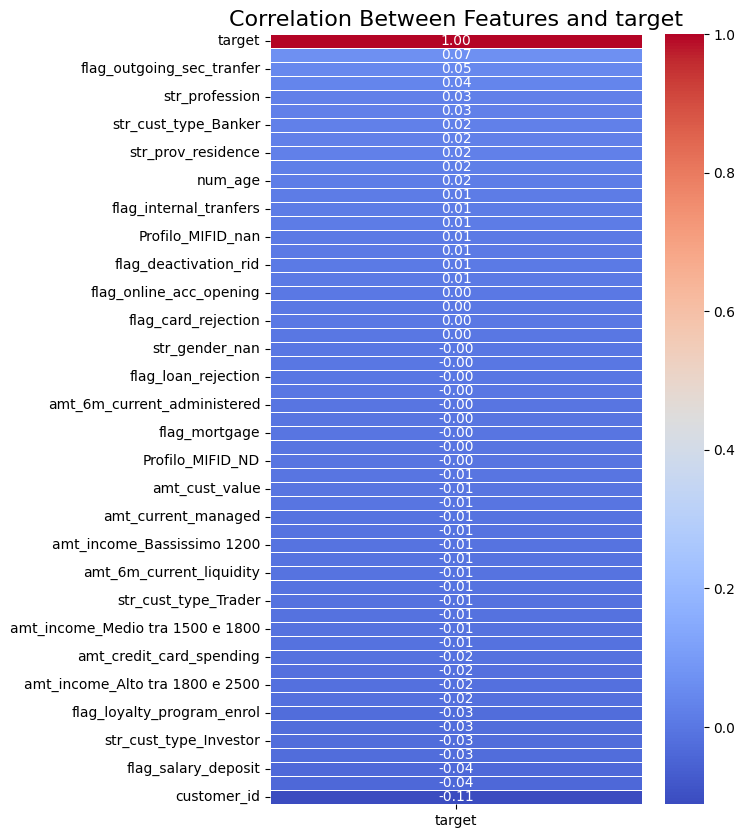

In [14]:
#CORRELATION MATRIX
#WE ARE GOING TO UNDERSTAND THAT THE PROBLEM IS NOT LINEAR
#BECAUSE WE HAVEN'T ANY STRONG LINEAR CORRELATION BETWEEN TARGET AND FEATURES


correlation_matrix = dataset.corr()


target_column = "target"
correlation_with_target = correlation_matrix[[target_column]].sort_values(by=target_column, ascending=False)


plt.figure(figsize=(6, 10))


sns.heatmap(correlation_with_target,
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title(f"Correlation Between Features and {target_column}", fontsize=16)


plt.show()


In [15]:
#WE ARE GOING TO USE A SIMPLE MODEL XGBOOST IN ORDER TO UNDERSTAND WHICH FEATURES ARE REAL IMPORTANT
#FOR THIS KIND OF MODEL


X_train = dataset.drop('target', axis=1)
y_train = dataset['target']

model = XGBClassifier()
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
#NOW WE USE THE PREVIOUS MODEL TO CALCULATE THE 'GAIN' AND 'WEIGHT' OF EACH FEATURES
#IN ORDER TO UNDERSTAND THE REAL IMPORTANCE

booster = model.get_booster()

gain = booster.get_score(importance_type='gain')
weight = booster.get_score(importance_type='weight')


importance_df = pd.DataFrame({
    'Feature': list(set(gain.keys()).union(set(weight.keys()))),
    })


importance_df['Gain'] = importance_df['Feature'].map(gain).fillna(0)
importance_df['Weight'] = importance_df['Feature'].map(weight).fillna(0)


importance_df['Gain_norm'] = importance_df['Gain'] / importance_df['Gain'].max()
importance_df['Weight_norm'] = importance_df['Weight'] / importance_df['Weight'].max()


importance_df['Combined_Score'] = 0.5 * importance_df['Gain_norm'] + 0.5 * importance_df['Weight_norm']


importance_df = importance_df.sort_values(by='Combined_Score', ascending=False)

print(importance_df[['Feature', 'Gain', 'Weight', 'Combined_Score']])


                             Feature       Gain  Weight  Combined_Score
16                       customer_id  43.447659   343.0        1.000000
20             amt_current_liquidity  14.750250   297.0        0.602692
37          amt_6m_current_liquidity   5.127469   222.0        0.382623
6                            num_age   3.915529   198.0        0.333690
27                   amt_pricing_fee  15.637924   104.0        0.331566
7                     amt_cust_value   3.508164   199.0        0.330460
23                str_prov_residence   4.042261   160.0        0.279755
44          amt_current_administered  10.171940   108.0        0.274494
22                 str_prov_domicile   3.968857   145.0        0.257044
32            num_transactions_count   7.348812   112.0        0.247836
9     amt_tranfers_vs_no_competitors   6.817958   105.0        0.231523
36            num_year_first_account   4.699741   113.0        0.218808
17          amt_credit_card_spending   8.872003    77.0        0

In [17]:
#I TRYED TO DROP THE FEATURES WITH 'COMBINED SCORE'< 0.1
#BUT I HAVE HAD A WORST PERFORMANCE
#FOR SURE THE 'FEATURES NOISE' ISN'T IN THOSE FEATURES


#dataset1 = dataset.drop(columns=['flag_mult_account_ownership', 'flag_internal_tranfers', 'num_trading_activities_count'])
                                 #'str_gender', 'flag_online_acc_opening', 'amt_income', 'flag_loyalty_program_enrol',
                                 #'flag_loan_rejection', 'flag_request_info_closure', 'flag_deactivation_rid',
                                 #'num_loyalty_points', 'str_cust_type', 'amt_current_managed', 'num_existing_services' ])


In [18]:
#SEEING IF OUR DATASET IS UNBALANCE
#YES IT IS UNBALANCE

print(dataset['target'].value_counts())

target
0    375386
1      1983
Name: count, dtype: int64


In [19]:
#DEFINE X AND y (TRAIN-TEST SPLIT)

X = dataset.drop('target', axis=1)
y = dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [20]:
#BALANCE THE DATASET

#rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

#X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


#print(y_resampled.value_counts())


sample_size = 50000
dataset_sample = dataset.sample(sample_size, random_state=42)
print(f"\nWorking with a sample of {sample_size} records")

X_resampled = dataset_sample.drop('target', axis=1)
y_resampled = dataset_sample['target']

dataset_sample.shape
print(dataset_sample['target'].value_counts())


Working with a sample of 50000 records
target
0    49755
1      245
Name: count, dtype: int64


# Phase 2 - Modelling

In [21]:
#APPLY THE MODEL XGBOOST

model = XGBClassifier(
    max_depth=3,            # LESS DEPTH, LESS OVERFITTING
    min_child_weight=10,     # MORE WEIGHT FOR SPLITTING
    gamma=0.2,              # SPLIT ONLY IF IT IS NECESSARY
    subsample=0.7,          # non usa tutti i dati per ogni albero
    colsample_bytree=0.7,   # non usa tutte le feature per ogni albero
    reg_alpha=1,          # TO BALANCE THE IMPORTANT FEATURES
    reg_lambda=1,         # TO BALANCE THE IMPORTANT FEATURES
    scale_pos_weight=1.5,     # CLASS BALANCE
    learning_rate=0.1,
    n_estimators=300,       # TREE NUMBER
    random_state=42
)



model.fit(X_resampled, y_resampled)


#MORE COMPLEX MODEL BUT WORST (OVERFITTED)

#max_depth=4,            # LESS DEPTH, LESS OVERFITTING
    #min_child_weight=8,     # MORE WEIGHT FOR SPLITTING
    #gamma=0.2,              # SPLIT ONLY IF IT IS NECESSARY
    #subsample=0.8,          # non usa tutti i dati per ogni albero
    #colsample_bytree=0.8,   # non usa tutte le feature per ogni albero
    #reg_alpha=0.5,          # TO BALANCE THE IMPORTANT FEATURES
    #reg_lambda=0.5,         # TO BALANCE THE IMPORTANT FEATURES
    #scale_pos_weight=1,     # CLASS BALANCE
    #learning_rate=0.05,
    #n_estimators=500,       # TREE NUMBER
    #random_state=42



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
#SCORE ON TRAIN DATAS WITH PROBA AND RELATIVE BEST THRESHOLD

y_proba_train = model.predict_proba(X_train)[:, 1]

threshold = 0.27

y_pred_train = (y_proba_train >= threshold).astype(int)


print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall:", recall_score(y_train, y_pred_train))
print("F1 Score:", f1_score(y_train, y_pred_train))



Accuracy: 0.9940409745110055
Precision: 0.43263757115749524
Recall: 0.4312736443883985
F1 Score: 0.4319545311019893


In [23]:
#SCORE ON TEST DATAS WITH PROBA AND RELATIVE BEST THRESHOLD

y_proba_test = model.predict_proba(X_test)[:, 1]

threshold = 0.28

y_pred_test = (y_proba_test >= threshold).astype(int)


print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))


Accuracy: 0.995972122850253
Precision: 0.6153846153846154
Recall: 0.6246851385390428
F1 Score: 0.62


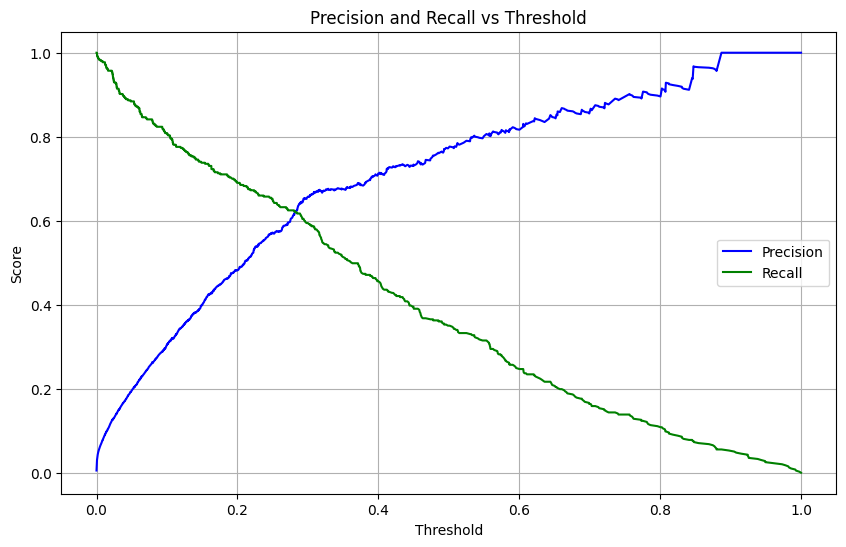

Optimal Threshold where Precision and Recall intersect: 0.28


In [24]:
#PRECISION RECALL CURVE -TO IDENTIFYING THE BEST THRESHOLD

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
thresholds = np.append(thresholds, 1.0)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


# OPTIMAL THRESHOLD WHERE PRECISION AND RECALL INTERSECT
diff = np.abs(precision - recall)
optimal_idx = np.argmin(diff)  # MIN DIFFERENCE BETWEEN PRECISION AND RECALL
optimal_threshold = thresholds[optimal_idx]  # BEST THRESHOLD


print(f"Optimal Threshold where Precision and Recall intersect: {optimal_threshold:.2f}")

In [25]:
#WE CALCULATE THE ACCURACY-PRECISION-RECALL-F1 SCORE FOR BOTH TRAIN AND TEST DATASET IN ORDER TO UNDERSTAND IF THE MODEL WAS OVERFITTED
#BUT IT ISN'T BECAUSE WE HAVE GOOD INDEX SCORE BOTH IN TRAIN AND TEST DATASET.

#WITH THE PRECISION RECALL CURVE WE ARE ABLE TO FIND THE BEST THRESHOLD TO HAVE A GOOD PRECISION AND RECALL

#ACCURACY: MEANS HOW MUCH THE MODEL'S PREDICTIONS ARE CORRECT.
#PRECISION: TELLS US HOW MUCH WE CAN TRUST THE MODEL WHEN IT SAYS “THIS CUSTOMER IS GOING TO LEAVE”.
#RECALL: IT MEASURES HOW GOOD YOU ARE AT NOT MISSING CUSTOMERS AT RISK.
#F1 SCORE: THIS IS THE HARMONIC MEAN OF PRECISION AND RECALL.
          #IT’S USEFUL WHEN YOU WANT A BALANCE BETWEEN NOT HAVING TOO MANY FALSE POSITIVES (PRECISION)
          #AND NOT MISSING TOO MANY REAL CHURN CASES (RECALL).

# Phase 3 - Evaluation

  Preparing metadata (setup.py) ... done
  Created wheel for mljar-scikit-plot: filename=mljar_scikit_plot-0.3.12-py3-none-any.whl size=32014 sha256=101bbdb8387ac66d6cd8780c51a42dccb1649cc2986bea06f0dcf0468ddce256
  Stored in directory: /root/.cache/pip/wheels/e2/2d/3e/8afe0632e7b03c3ae7b8048f88f0dcca4355b32d31abaea3ba
Successfully built mljar-scikit-plot


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

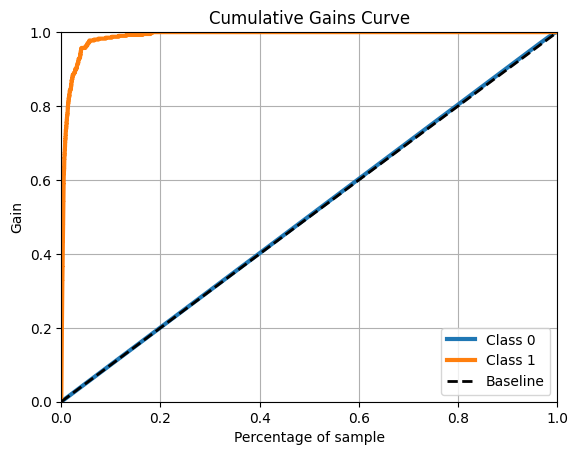

In [26]:
#CUMULATIVE GAINS CURVE
#WE NOTICE THAT OUR MODEL IS VERY EFFECTIVE AT CORRECTLY RANKING CUSTOMERS AT RISK OF CHURN

!pip install mljar-scikit-plot
import scikitplot as skplt

y_proba_test_ = model.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_proba_test_)

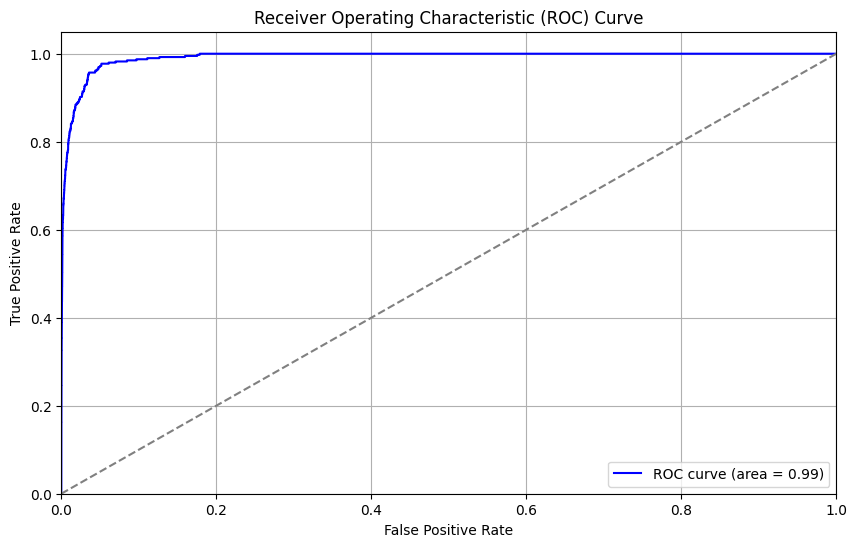

In [27]:
#ROC
# ROC CURVE AREA = 0.99 MEANS THAT OUR MODEL MAKES VERY FEW MISTAKES WHEN CLASSIFYING CUSTOMERS AT RISK

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test_[:,1], pos_label=1, drop_intermediate=(True))

roc_analysis = pd.DataFrame()
roc_analysis['threshold'] = thresholds
roc_analysis['fpr'] = fpr
roc_analysis['tpr'] = tpr




plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # linea diagonale (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

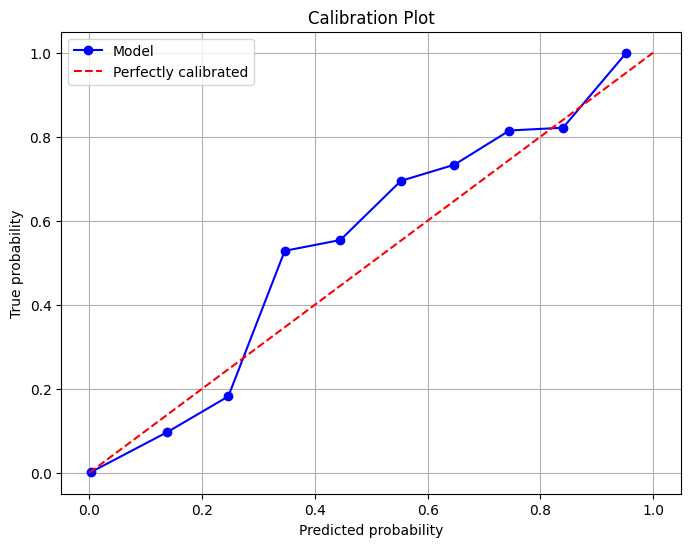

In [28]:
#CALIBRATION PLOT
#OUR MODEL IS ALMOST PERFECTLY CALIBRATED

from sklearn.calibration import calibration_curve

y_proba_test = model.predict_proba(X_test)[:, 1]


prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)


plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='red')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Phase 4 - Presenting ROI to Business Users




In [29]:
# Model ROI analysis
# hypotizing Costs and Benefits
contact_cost = 5
revenue_profit = 40


In [30]:
print(y_test.shape)
print(y_proba_test.shape)
print(y_pred_test.shape)


(75474,)
(75474,)
(75474,)


In [31]:
# preparing our analysis table
analisi_roi = pd.DataFrame()
analisi_roi['target'] = y_test
analisi_roi['score']= y_proba_test
# we need "predefined" score bins - classes
# class_score = np.linspace(0.0,1.0,num=10, endpoint=True)
import numpy as np
class_score = np.arange(0.0,1.01,step=0.01)

analisi_roi

,target,score
363909,0,0.000004
15925,0,0.004337
100322,0,0.000065
127945,0,0.000012
290573,0,0.000097
...,...,...
179014,0,0.000012
225309,0,0.000136
295908,0,0.000057
373291,0,0.000193


In [32]:
# we bin scores according to predefined classes
analisi_roi['score_bin'] = pd.cut(analisi_roi['score'],bins=class_score,labels=False, include_lowest=True)
# let's have a look at the score bins
analisi_roi.score_bin.value_counts(dropna=False).sort_index()


analisi_roi

,target,score,score_bin
363909,0,0.000004,0
15925,0,0.004337,0
100322,0,0.000065,0
127945,0,0.000012,0
290573,0,0.000097,0
...,...,...,...
179014,0,0.000012,0
225309,0,0.000136,0
295908,0,0.000057,0
373291,0,0.000193,0


In [33]:

# we count the number of real positives in the test sample
tot_positivi_test = np.sum(y_test == 1)

# let's compute the results for each score bin
# we group by score_bin
analisi_roi_agg = analisi_roi.groupby('score_bin').agg(segnalati=('target','count'),hit=('target','sum'))
analisi_roi_agg.sort_values('score_bin', ascending=False, inplace=True)

analisi_roi_agg

,segnalati,hit
score_bin,,
99,3,3
98,3,3
97,2,2
96,1,1
94,3,3
...,...,...
4,285,4
3,415,8
2,733,17


In [34]:
# we compute some cumulative sum
analisi_roi_agg['segnalati_cum'] = analisi_roi_agg['segnalati'].cumsum()
analisi_roi_agg['hit_cum'] = analisi_roi_agg['hit'].cumsum()


analisi_roi_agg

,segnalati,hit,segnalati_cum,hit_cum
score_bin,,,,
99,3,3,3,3
98,3,3,6,6
97,2,2,8,8
96,1,1,9,9
94,3,3,12,12
...,...,...,...,...
4,285,4,2078,355
3,415,8,2493,363
2,733,17,3226,380


In [35]:
# we compute the metrics we care about
analisi_roi_agg['precision'] = analisi_roi_agg['hit_cum'] / analisi_roi_agg['segnalati_cum']
analisi_roi_agg['recall']    = analisi_roi_agg['hit_cum'] / tot_positivi_test
analisi_roi_agg['tot_contact_cost'] = analisi_roi_agg['segnalati_cum'] * contact_cost
analisi_roi_agg['tot_revenue_profit'] = analisi_roi_agg['hit_cum'] * revenue_profit


In [36]:
# we compute the final ROI
analisi_roi_agg['roi'] = analisi_roi_agg['tot_revenue_profit'] - analisi_roi_agg['tot_contact_cost']

# what do we see? Which is the optimal threshold?
# what can we say to Marketing Boss?
analisi_roi_agg

,segnalati,hit,segnalati_cum,hit_cum,precision,recall,tot_contact_cost,tot_revenue_profit,roi
score_bin,,,,,,,,,
99,3,3,3,3,1.000000,0.007557,15,120,105
98,3,3,6,6,1.000000,0.015113,30,240,210
97,2,2,8,8,1.000000,0.020151,40,320,280
96,1,1,9,9,1.000000,0.022670,45,360,315
94,3,3,12,12,1.000000,0.030227,60,480,420
...,...,...,...,...,...,...,...,...,...
4,285,4,2078,355,0.170837,0.894207,10390,14200,3810
3,415,8,2493,363,0.145608,0.914358,12465,14520,2055
2,733,17,3226,380,0.117793,0.957179,16130,15200,-930


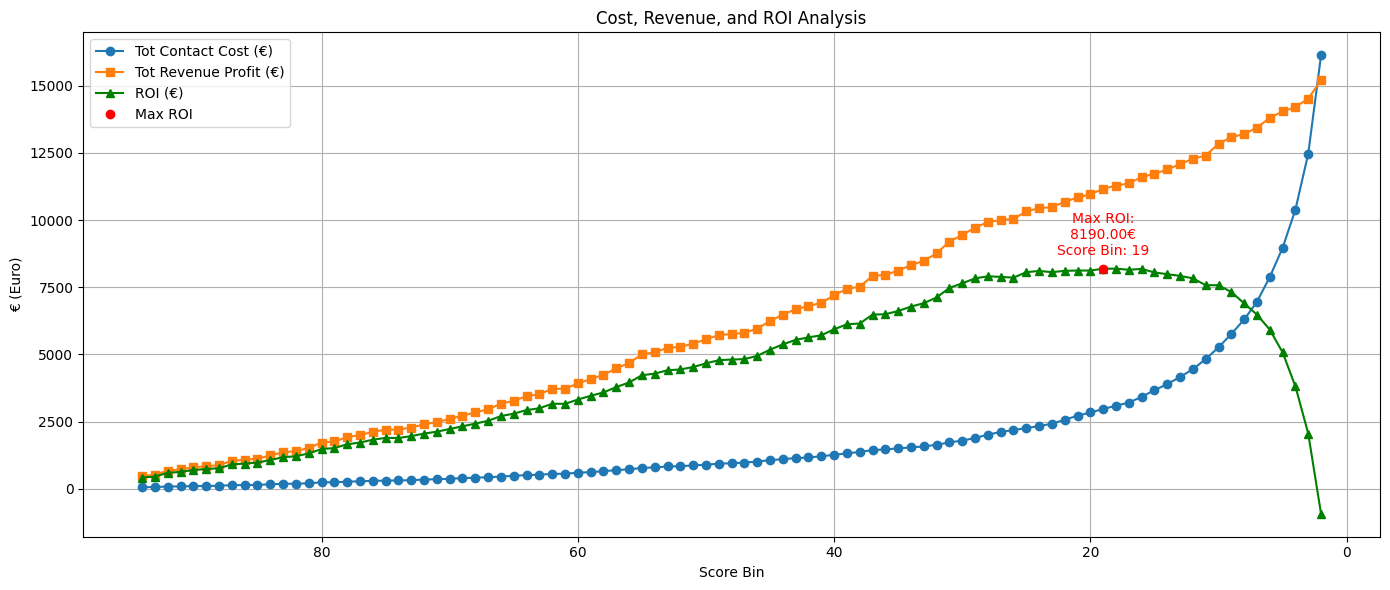

In [37]:
import matplotlib.pyplot as plt

# Calcolo ROI cumulativo (solo una volta!)
analisi_roi_agg['roi'] = analisi_roi_agg['tot_revenue_profit'] - analisi_roi_agg['tot_contact_cost']

# Seleziona solo i bin da 95 a 50 in ordine decrescente
score_bin_range = list(range(94, 1, -1))  # da 95 a 50 inclusi, in ordine decrescente
analisi_roi_agg_sorted = analisi_roi_agg.loc[score_bin_range]

# Estrai le serie
score_bins = analisi_roi_agg_sorted.index
contact_cost = analisi_roi_agg_sorted['tot_contact_cost']
revenue_profit = analisi_roi_agg_sorted['tot_revenue_profit']
roi = analisi_roi_agg_sorted['roi']

# Trova il massimo ROI e l’indice relativo
max_roi_value = roi.max()
max_roi_index = roi.idxmax()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(score_bins, contact_cost, 'o-', label='Tot Contact Cost (€)')
plt.plot(score_bins, revenue_profit, 's-', label='Tot Revenue Profit (€)')
plt.plot(score_bins, roi, 'g^-', label='ROI (€)')

# Evidenziazione max ROI
plt.plot(max_roi_index, max_roi_value, 'ro', label='Max ROI')
plt.text(max_roi_index, max_roi_value + 500,
         f'Max ROI:\n{max_roi_value:.2f}€\nScore Bin: {max_roi_index}',
         color='red', fontsize=10, ha='center')

# Inverti l'asse x per renderlo decrescente
plt.gca().invert_xaxis()

# Layout e info
plt.title("Cost, Revenue, and ROI Analysis")
plt.xlabel("Score Bin")
plt.ylabel("€ (Euro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# Filtriamo i dati per score_bin uguale a 19
bin_19_data = analisi_roi_agg[analisi_roi_agg.index == 19]

# Se il bin 19 esiste, visualizziamo i valori
if not bin_19_data.empty:
    print("Valori per score bin 19:")
    print(f"Segnalati cumulativi: {bin_19_data['segnalati_cum'].values[0]}")
    print(f"Hit cumulativi: {bin_19_data['hit_cum'].values[0]}")
    print(f"Precision: {bin_19_data['precision'].values[0]}")
    print(f"Recall: {bin_19_data['recall'].values[0]}")
    print(f"Totale Contact Cost: {bin_19_data['tot_contact_cost'].values[0]}")
    print(f"Totale Revenue Profit: {bin_19_data['tot_revenue_profit'].values[0]}")
    print(f"ROI: {bin_19_data['roi'].values[0]}")
else:
    print("Non ci sono dati per il bin 19.")


Valori per score bin 19:
Segnalati cumulativi: 594
Hit cumulativi: 279
Precision: 0.4696969696969697
Recall: 0.7027707808564232
Totale Contact Cost: 2970
Totale Revenue Profit: 11160
ROI: 8190
